# Random Forest in BoFire
## Imports

In [1]:
from bofire.benchmarks.multi import DTLZ2
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume
from bofire.samplers import PolytopeSampler
from bofire.strategies.random import RandomStrategy
from bofire.domain import Domain
from bofire.domain.features import OutputFeatures, ContinuousOutput, ContinuousInput, InputFeatures, MaximizeObjective
from bofire.strategies.botorch.qehvi import BoTorchQehviStrategy
from functools import partial
from bofire.models.random_forest import RandomForest
from bofire.models.torch_models import BotorchModels
from bofire.utils.enum import SamplingMethodEnum
import matplotlib.pyplot as plt



## Setup a RF

In [15]:
benchmark = DTLZ2(dim=6)

experiments = benchmark.f(benchmark.domain.inputs.sample(20), return_complete=True)

# you can use the hyperparams from sklearn
rf = RandomForest(
    input_features=benchmark.domain.inputs,
    output_features=OutputFeatures(features=[benchmark.domain.outputs[0]]),
    n_estimators=100
    )

cv_train, cv_test, _ = rf.cross_validate(experiments)

cv_test.get_metrics()


,MAE,MSD,R2,MAPE,PEARSON,SPEARMAN,FISHER
0,0.242355,0.084901,0.268884,0.383225,0.623821,0.61203,0.011507


## Setup an optimization

In [16]:
## Random Forest

benchmark = DTLZ2(dim=6)

recommender = BoTorchQehviStrategy(domain=benchmark.domain, ref_point={"f_0": 1.1, "f_1": 1.1}, 
    model_specs=BotorchModels(models=[
        RandomForest(
            input_features=benchmark.domain.inputs,
            output_features=OutputFeatures(features=[benchmark.domain.outputs[0]])), 
        RandomForest(
            input_features=benchmark.domain.inputs,
            output_features=OutputFeatures(features=[benchmark.domain.outputs[1]])),
    ]))

experiments = benchmark.f(benchmark.domain.inputs.sample(10), return_complete=True)
recommender.tell(experiments=experiments)

for i in range(10):
    samples = benchmark.domain.inputs.sample(512, method=SamplingMethodEnum.SOBOL)
    candidates = recommender.ask(1, candidate_pool=samples)
    candidates = candidates.reset_index(drop=True)
    new_experiments = benchmark.f(candidates[benchmark.domain.inputs.get_keys().copy()], return_complete=True)
    recommender.tell(experiments=new_experiments)



## Plot the Performance

Comparing with random in the `/bechmarks/002-DLZ2.ipynb` notebook shows wors perfomance than the Random Strategy with is due to the pure performance of the non hyperoptimized RF.

Text(0, 0.5, 'f_1')

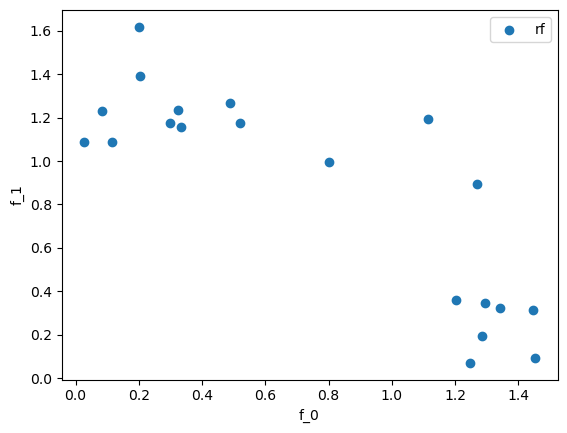

In [17]:

fig, ax = plt.subplots()

ax.scatter(benchmark.domain.experiments.f_0, benchmark.domain.experiments.f_1, label = "rf")

ax.legend()

ax.set_xlabel("f_0")
ax.set_ylabel("f_1")